In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf

# Import and inspect data

## Import

In [120]:
def import_data():
    """Import training and testing data, as data and labels"""
    
    # Import in pandas (np.genfromtxt is too slow)
    tr_pd = pd.read_csv('data_train.csv', header=None)
    tst_pd = pd.read_csv('data_test.csv', header=None)
    
    # Split data and labels
    tr_data = np.array(tr_pd.loc[:, 1:])
    tr_labels = np.array(tr_pd.loc[:, 0])
    tst_data = np.array(tst_pd.loc[:, 1:])
    tst_labels = np.array(tst_pd.loc[:, 0])
    
    return tr_data/255, tst_data/255, tr_labels, tst_labels

In [121]:
g_tr_data, g_tst_data, g_tr_labels, g_tst_labels = import_data()

## Inspect

In [81]:
def inspect_number(data, img_nums, savefig=False):
    """Display image. img_nums should be entered as list."""
    
    num_images = len(img_nums)
    # Reshape datasets into pixel array
    data_rs = np.reshape(data, newshape=(data.shape[0], 28, 28))
    
    figsize = (10, 1)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    for k in range(num_images):
        ax = axes[k]
        ax.imshow(data_rs[img_nums[k]], cmap='Greys')
        ax.set_axis_off()
    if savefig is not False:
        plt.savefig(savefig)
    plt.show()

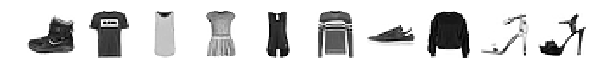

In [94]:
inspect_number(g_tr_data, np.arange(10), savefig='figs/benchmark.pdf')

# Build VAE in Tensorflow

In [104]:
class AutoEncoder():
    """Autoencoder. For most examples, self.inp=self.tgt, but these are considered 
    independent variables to make extensions more straightforward."""
    
    def __init__(self, dim_z, dim_conv1, dim_conv2, dim_hidden, learn_param):
        self.tr_data, self.tst_data, self.tr_labels, self.tst_labels = import_data()
        self.batch_size = 100
        self.dim_z = dim_z    # Number of dimensions of latent space
        self.dim_conv1 = dim_conv1    # Number of convolution operators in first layer
        self.dim_conv2 = dim_conv2    # Number of convolution operators in second layer
        self.dim_hidden = dim_hidden    # Number of nodes in hidden layer
        self.learn_param = learn_param
        
        self.inp = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='inputs')
        self.tgt = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='targets')
        self.feedfwd_z = tf.placeholder(dtype=tf.float32, shape=[None, dim_z], name='feedfwd_z')
        self.sess = tf.Session()
        self._build_graph()
        self.sess.run(tf.initializers.global_variables())
    
    def _build_graph(self):
        """Build neural network"""
        initializer = tf.glorot_uniform_initializer()
        
        # Encoder: convolutional neural network
        enc_h = tf.reshape(self.inp, shape=[-1, 28, 28, 1])    
        enc_h = tf.layers.conv2d(enc_h, self.dim_conv1, kernel_size=[5, 5], strides=[2, 2], padding='same', 
                             kernel_initializer=initializer, activation=tf.nn.relu, 
                             name='enc_conv1')    # 28x28 -> 14x14xdim_conv1
        print(enc_h)
        enc_h = tf.layers.conv2d(enc_h, self.dim_conv2, kernel_size=[5, 5], strides=[2, 2], padding='same',
                             kernel_initializer=initializer, activation=tf.nn.relu, 
                             name='enc_conv2')    # 14x14xdim_conv1 -> 7x7xdim_conv2
        print(enc_h)
        enc_h = tf.reshape(enc_h, [-1, 7*7*self.dim_conv2])    # 7x7xdim_conv2 -> flat
        print(enc_h)
        enc_h = tf.layers.dense(enc_h, self.dim_hidden, kernel_initializer=initializer, 
                                activation=None, name='enc_dense1') 
        print(enc_h)

        # Bottleneck with reparametrisation trick
        self.mu = tf.layers.dense(enc_h, self.dim_z, kernel_initializer=initializer,
                                  activation=None, name='mu')
        print(self.mu)
        self.log_sigma = tf.layers.dense(enc_h, self.dim_z, kernel_initializer=initializer,
                                         activation=None, name='log_sigma')
        print(self.log_sigma)
        self.z = tf.add(self.mu, 
                        tf.multiply(tf.exp(0.5 * self.log_sigma), 
                                    tf.random.normal(shape=[tf.shape(self.mu)[0], 
                                                            self.dim_z]),
                        name='z'))
        print(self.z)

        # Decoder: deconvolutional neural network
        dec_h = tf.layers.dense(self.z, self.dim_hidden, kernel_initializer=initializer,
                                activation=None, name='dec_dense1')
        print(dec_h)
        dec_h = tf.layers.dense(self.z, 7*7*self.dim_conv2, kernel_initializer=initializer, 
                            activation=tf.nn.relu, name='dec_dense2')    # flat -> 7x7xdim_conv2
        print(dec_h)
        dec_h = tf.reshape(dec_h, [-1, 7, 7, self.dim_conv2])
        print(dec_h)
        dec_h = tf.layers.conv2d_transpose(dec_h, self.dim_conv1, kernel_size=[5, 5], 
                                           strides=[2, 2], padding='same', 
                                           kernel_initializer=initializer, activation=tf.nn.relu, 
                                           name='dec_deconv1')    # 7x7xdim_conv2 -> 14x14xdim_conv1
        print(dec_h)
        dec_h = tf.layers.conv2d_transpose(dec_h, 1, kernel_size=[5, 5], strides=[2, 2], padding='same', 
                             kernel_initializer=initializer, activation=tf.nn.sigmoid, 
                             name='dec_deconv2')    # 14x14xdim_conv1 -> 28x28
        print(dec_h)
        self.out = tf.reshape(dec_h, [-1, 784])
    
        # Optimizer: sum of generation loss and KL divergence
        self.loss_gen = -tf.reduce_sum(self.tgt * tf.log(1e-10 + self.out) + \
                                       (1 - self.tgt) * tf.log(1e-10 + 1 - self.out), 
                           axis=1)
        self.loss_KL = \
            0.5 * tf.reduce_sum(tf.square(self.mu) + tf.square(tf.exp(self.log_sigma)) - \
                                tf.log(tf.square(tf.exp(self.log_sigma))) - 1, axis=1)
        self.cost = tf.reduce_mean(tf.add(self.loss_gen, self.loss_KL))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.learn_param).minimize(self.cost)
        
        # Second decoder to feedforward z values
        dec_h2 = tf.layers.dense(self.feedfwd_z, self.dim_hidden, kernel_initializer=initializer,
                                activation=None, name='dec_dense1', reuse=True)
        print(dec_h2)
        dec_h2 = tf.layers.dense(self.feedfwd_z, 7*7*self.dim_conv2, kernel_initializer=initializer, 
                            activation=tf.nn.relu, name='dec_dense2', reuse=True)
        print(dec_h2)
        dec_h2 = tf.reshape(dec_h2, [-1, 7, 7, self.dim_conv2])
        print(dec_h2)
        dec_h2 = tf.layers.conv2d_transpose(dec_h2, self.dim_conv1, kernel_size=[5, 5], strides=[2, 2], 
                                            padding='same', 
                                            kernel_initializer=initializer, activation=tf.nn.relu, 
                                            name='dec_deconv1', 
                                            reuse=True)    # 7x7xdim_conv2 -> 14x14xdim_conv1
        print(dec_h2)
        dec_h2 = tf.layers.conv2d_transpose(dec_h2, 1, kernel_size=[5, 5], strides=[2, 2], padding='same', 
                                            kernel_initializer=initializer, activation=tf.nn.sigmoid, 
                                            name='dec_deconv2', reuse=True)    # 14x14xdim_conv1 -> 28x28
        print(dec_h2)
        self.feedfwd_out = tf.reshape(dec_h2, [-1, 784])
        
    def evaluate_AE_outputs(self, data_inp, data_tgt):
        """Run the variational autoencoder on some data and evaluate the mean squared error"""
        feed_dict = {self.inp: data_inp, self.tgt: data_tgt}
        z, outputs, cost = self.sess.run([self.z, self.out, self.cost], feed_dict=feed_dict)
        return z, outputs, cost
        
    def evaluate_z_outputs(self, z):
        """Run the decoder given some z values"""
        feed_dict = {self.feedfwd_z: z}
        outputs = self.sess.run(self.feedfwd_out, feed_dict=feed_dict)
        return outputs
    
    def test_same(self):
        z, outputs, cost = self.evaluate_AE_outputs(self.tr_data[0:3], self.tr_data[0:3])
        print(outputs)
        outputs = self.evaluate_z_outputs(z)
        print(outputs)
        
    def make_minibatch(self, data_inp, data_tgt, batch_num):
        """Form a minibatch from the data"""
        llim = batch_num * self.batch_size
        rlim = (batch_num + 1) * self.batch_size
        return data_inp[llim:rlim], data_tgt[llim:rlim]
    
    def estimate_plots(self, data_inp, img_nums, savefig=False):
        """Plot the autoencoder estimates over some images"""
        self.run_size = data_inp.shape[0]
        estimates = self.evaluate_AE_outputs(data_inp[img_nums], data_inp[img_nums])[1]
        # print(np.round(estimates[0, :10], 20))   # For debugging
        inspect_number(estimates, img_nums, savefig=savefig)
        
    def plot_z(self, data_z, data_labels, savefig=False):
        """Plot z values in 2-space (if z-space is 2-dimensional)"""
        fig, ax = plt.subplots()
        for label in range(10):
            data = data_z[data_labels == label]
            ax.scatter(data[:, 0], data[:, 1])
        ax.set_xlabel('z1')
        ax.set_ylabel('z2')
        plt.axis('equal')
        if savefig:
            plt.savefig('z_output_pic.pdf')
        plt.show()
    
    def train_iteration(self, data_inp, data_tgt):
        """Do one training iteration over the input data"""
        self.run_size = data_inp.shape[0]
        feed_dict = {self.inp: data_inp, self.tgt: data_tgt}
        _, out = self.sess.run([self.optimizer, self.out], feed_dict=feed_dict)
        
    def train_full(self, num_epochs, info=True, infoplots=False):
        """Train neural network and keep track of progress by (cross) validating"""
        
        # batch_size must divide num_tr_points
        num_tr_pts = self.tr_data.shape[0]
        num_tst_pts = self.tst_data.shape[0]
        num_batches = int(round(num_tr_pts / self.batch_size)) 
        
        # Train the MLP and keep track of the errors across training and testing datasets
        batch_nums, epochs, tr_costs, tst_costs = \
                np.array([]), np.array([]), np.array([]), np.array([])
        for epoch in range(num_epochs):
            for batch_num in range(num_batches):
                # Input proportion correctly identified across training, testing dataset
                if batch_num % 100 == 0:
                    tr_z, tr_out, tr_cost = self.evaluate_AE_outputs(self.tr_data, 
                                                                     self.tr_data)
                    tst_z, tst_out, tst_cost = self.evaluate_AE_outputs(self.tst_data, 
                                                                        self.tst_data)
#                    self.plot_z(tr_z, g_tr_labels)
                    if info is True:
                        print('Cost after {} batches: Tr {}, Tst {}'.format(
                            batch_num, tr_cost, tst_cost))
                    if infoplots is True: 
                        self.estimate_plots(self.tr_data, np.arange(10), savefig=False)
#                        self.estimate_plots(g_tr_data, np.arange(10), 
#                                            savefig=str(epoch) + '_' + str(batch_num) +'.pdf')
                    epochs = np.append(epochs, epoch)
                    batch_nums = np.append(batch_nums, batch_num)
                    tr_costs = np.append(tr_costs, tr_cost)
                    tst_costs = np.append(tst_costs, tst_cost)
                
                # Do the training over a minibatch
                mb_tr_inp, mb_tr_tgt = \
                    self.make_minibatch(self.tr_data, self.tr_data, batch_num=batch_num) 
                self.train_iteration(mb_tr_inp, mb_tr_tgt)    # Single training iteration
                
        if infoplots is True:
            self.estimate_plots(self.tr_data, np.arange(10), savefig='output.pdf')
#            self.plot_z(tr_z, g_tr_labels, savefig=False)
                
        costs = pd.DataFrame(np.vstack((epochs, batch_nums, tr_costs, tst_costs)).T, 
                             columns = ['epoch', 'batch', 'train', 'test'])
        return costs

# Train model and evaluate

In [117]:
tf.reset_default_graph()
model = AutoEncoder(dim_z=16, dim_conv1=64, dim_conv2=128, dim_hidden=64, 
                    learn_param=0.001)

Tensor("enc_conv1/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("enc_conv2/Relu:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 6272), dtype=float32)
Tensor("enc_dense1/BiasAdd:0", shape=(?, 64), dtype=float32)
Tensor("mu/BiasAdd:0", shape=(?, 16), dtype=float32)
Tensor("log_sigma/BiasAdd:0", shape=(?, 16), dtype=float32)
Tensor("Add:0", shape=(?, 16), dtype=float32)
Tensor("dec_dense1/BiasAdd:0", shape=(?, 64), dtype=float32)
Tensor("dec_dense2/Relu:0", shape=(?, 6272), dtype=float32)
Tensor("Reshape_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("dec_deconv1/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("dec_deconv2/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("dec_dense1_1/BiasAdd:0", shape=(?, 64), dtype=float32)
Tensor("dec_dense2_1/Relu:0", shape=(?, 6272), dtype=float32)
Tensor("Reshape_4:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("dec_deconv1_1/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("dec_deconv2_1/Sigmoi

In [ ]:
g_costs = model.train_full(num_epochs=4, info=True, infoplots=True)
g_costs.to_csv('costs.csv', float_format='%.2f')

In [212]:
# z are the coordinates of the images in latent z space
# Reshape it so that the first axis corresponds to the clothing type
flat_z = model.evaluate_AE_outputs(model.tr_data, model.tr_data)[0]
# Reshape z array so that first axis is clothing type
z = np.zeros(shape=(10, 6000, 16))
for k in range(10):
    z[k] = flat_z[g_tr_labels == k]

In [214]:
# feedfwd_z are the estimates of the images from the autoencoder
feedfwd_z = np.zeros(shape=(10, 6000, 784))
for k in range(10):
    feedfwd_z[k] = model.evaluate_z_outputs(z[k])

In [125]:
def interpolate_z(z_1, z_2):
    """Linearly interpolate z coordinates of z_1 and z_2"""
    interpolation = np.zeros(shape=(10, len(z_1)))    
    for k in range(10):
        interpolation[k] = z_1 + (k/9)*(z_2 - z_1)
    return interpolation

In [193]:
def interpolate_images(z_1, z_2, savefig=False):
    """Interpolate between two images in z space and the plot
    the results in image space. """
    interpolation = interpolate_z(z_1, z_2)    # Interpolate in z space
    # Feed forward into image space
    feedfwd_interpolation = model.evaluate_z_outputs(interpolation)
    inspect_number(feedfwd_interpolation, np.arange(10))

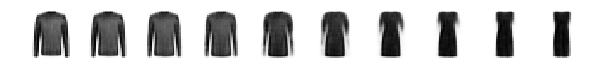

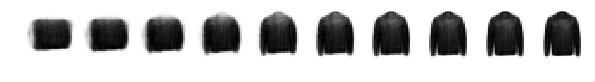

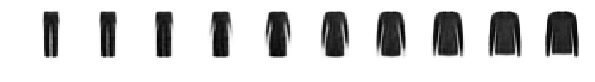

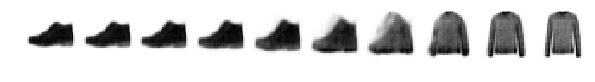

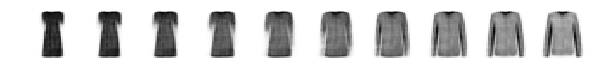

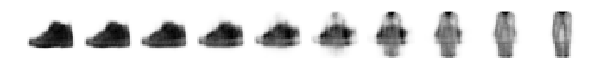

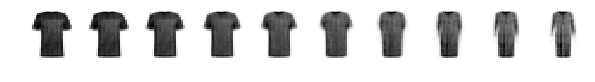

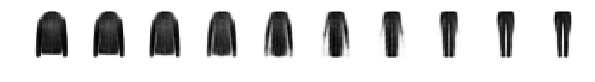

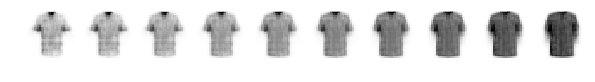

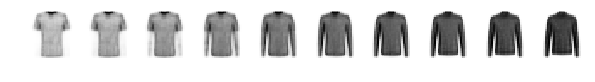

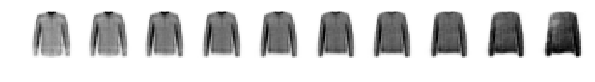

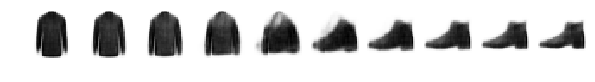

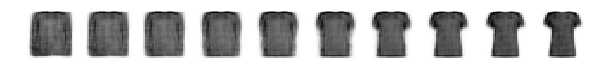

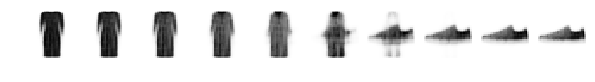

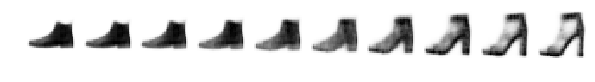

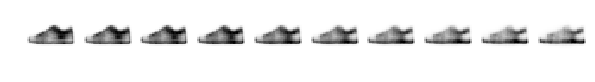

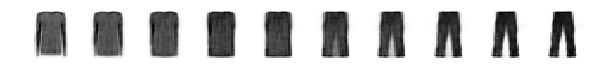

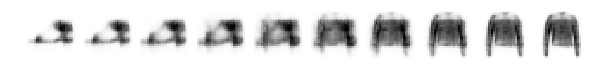

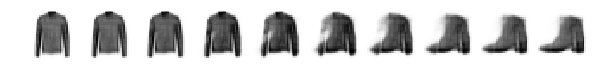

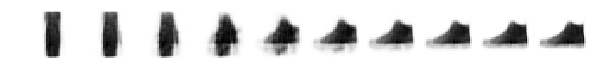

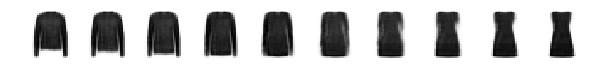

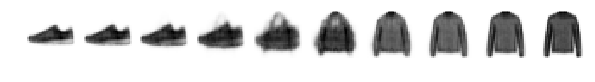

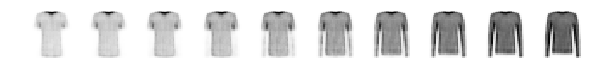

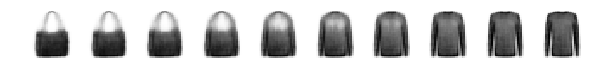

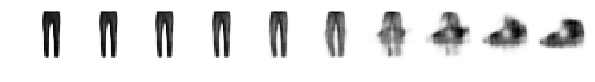

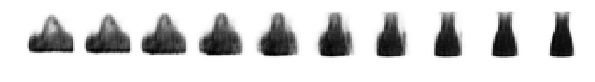

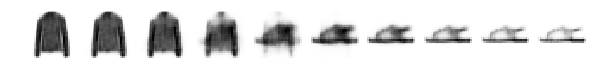

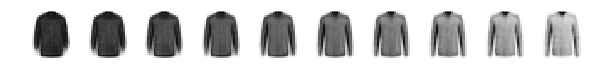

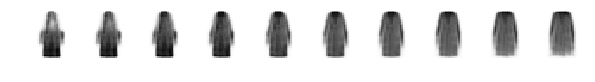

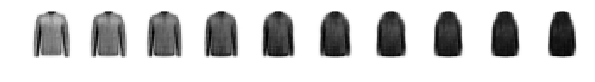

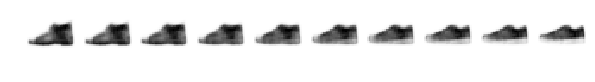

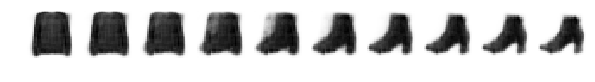

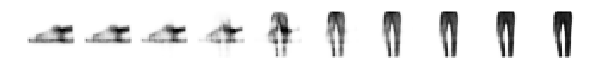

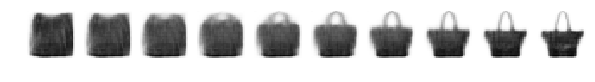

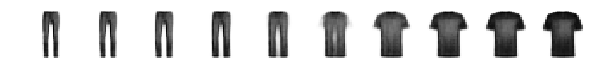

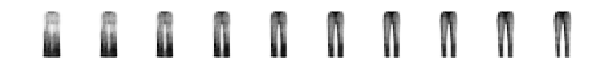

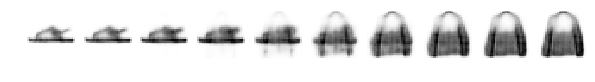

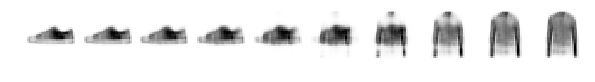

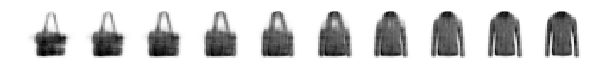

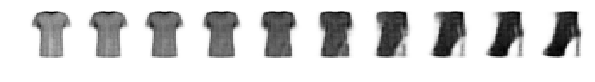

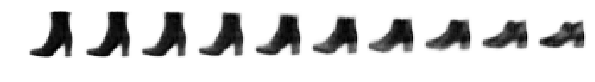

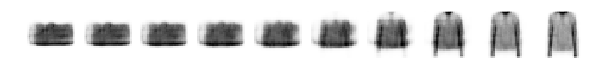

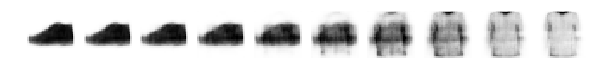

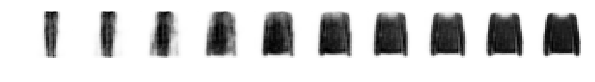

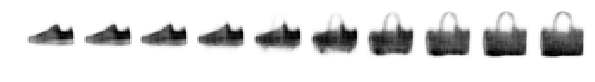

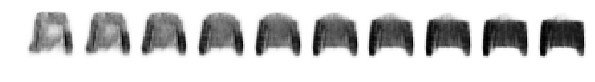

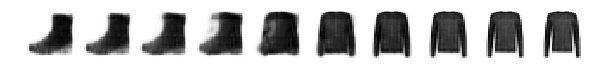

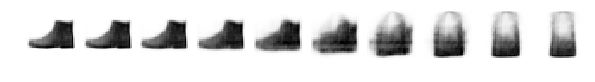

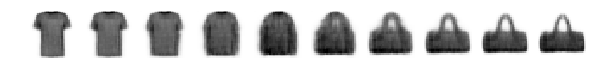

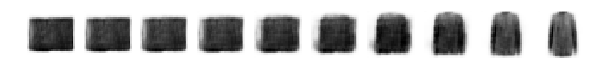

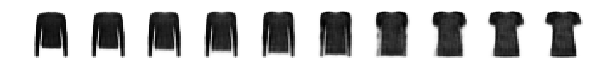

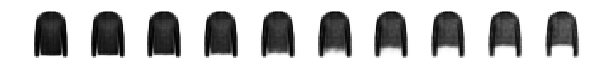

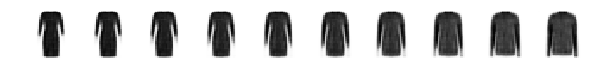

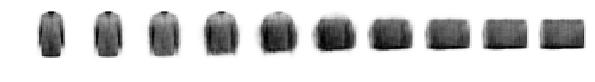

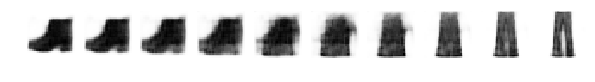

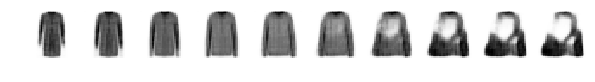

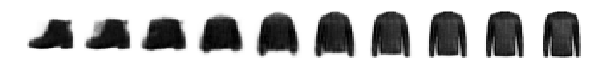

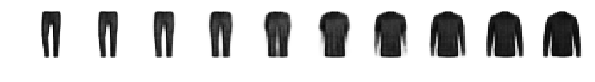

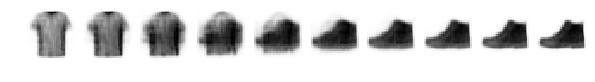

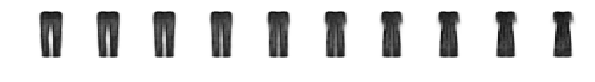

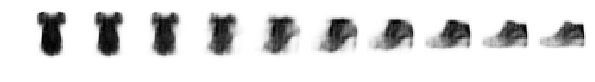

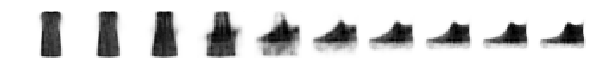

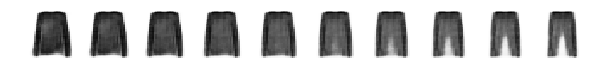

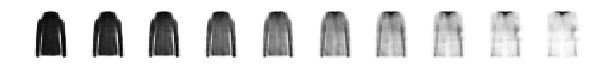

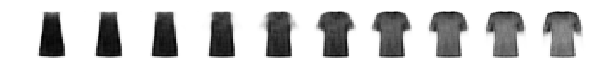

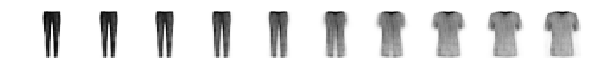

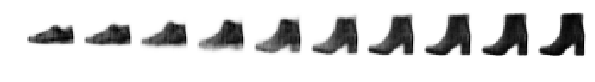

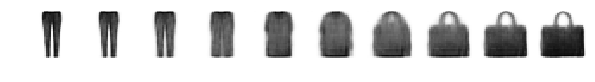

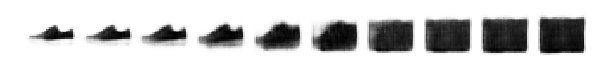

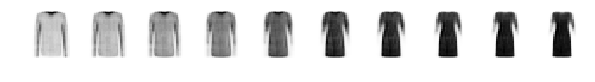

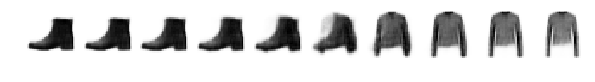

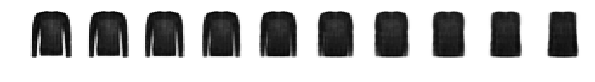

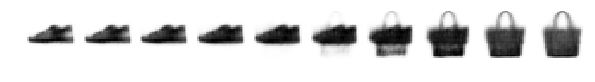

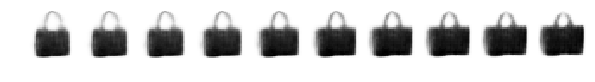

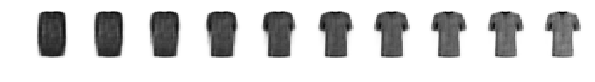

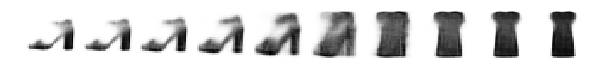

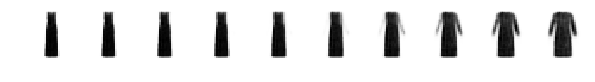

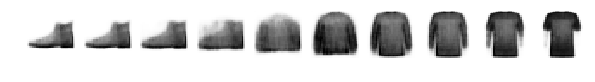

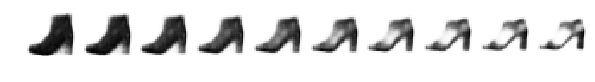

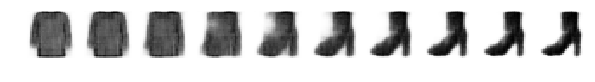

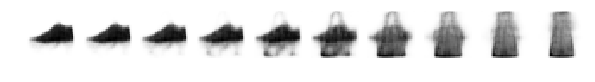

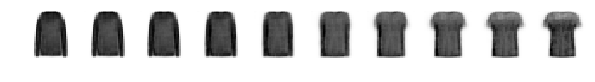

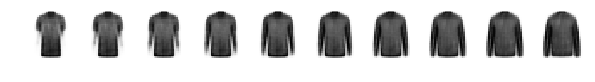

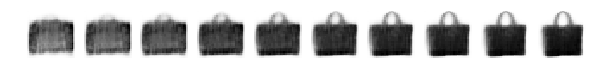

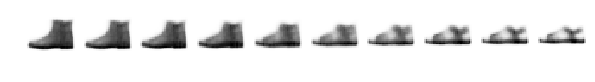

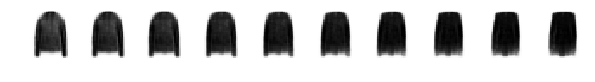

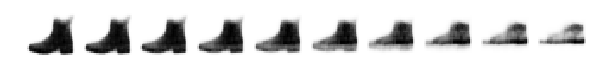

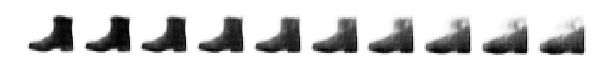

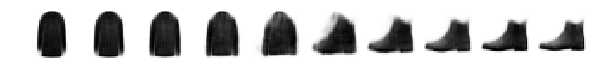

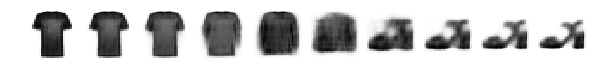

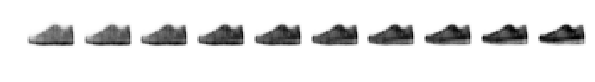

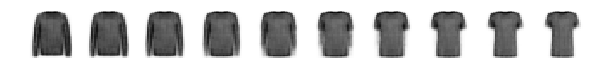

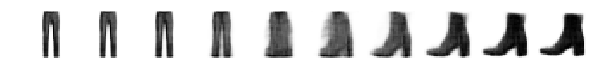

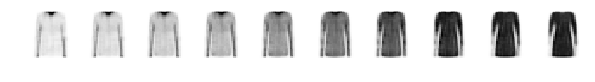

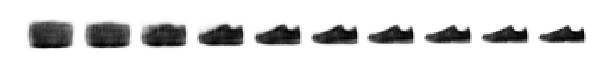

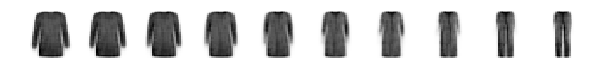

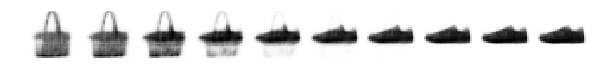

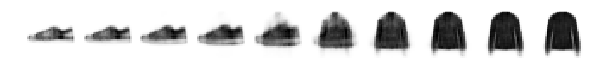

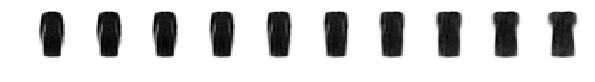

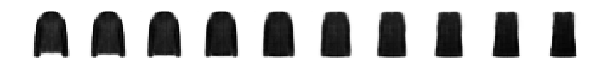

In [223]:
for k in range(100):
    z_1 = z[int(10*np.random.rand()), int(6000*np.random.rand())]
    z_2 = z[int(10*np.random.rand()), int(6000*np.random.rand())]
    interpolate_images(z_1, z_2)

In [190]:
z_handle = np.array([z_vals[8, 3] - z_vals[8, 8]])
feedfwd_z_handle = np.array(model.evaluate_z_outputs(z_handle))

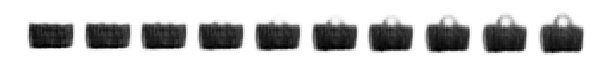

In [196]:
interpolate_images(z_vals[8, 8], z_vals[8, 8] + z_handle)

In [204]:
z_with_handles = z_vals + z_handle
feedfwd_z_with_handles = np.zeros(shape=(10, 6000, 784))
for k in range(10):
    feedfwd_z_with_handles[k] = \
        model.evaluate_z_outputs(z_with_handles[k])

(10, 6000, 784)


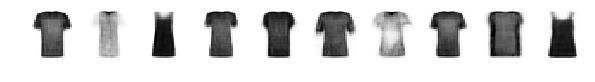

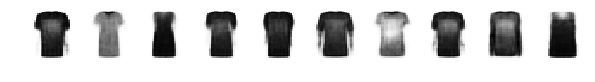

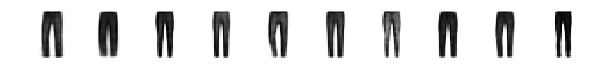

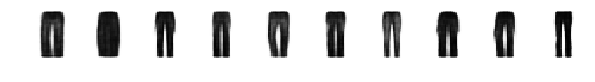

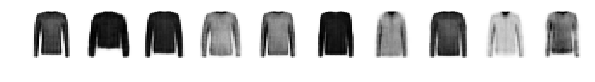

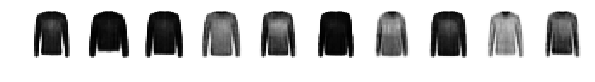

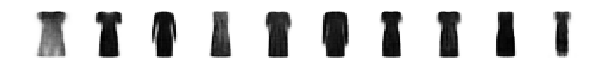

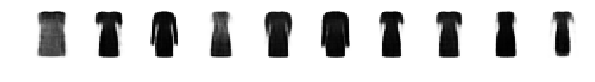

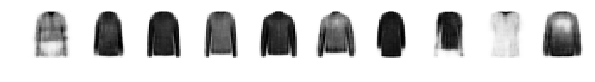

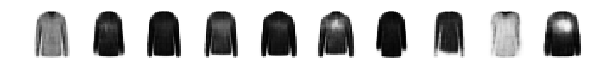

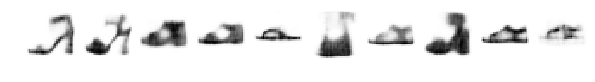

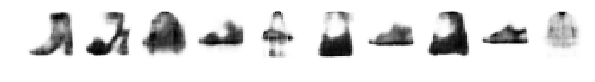

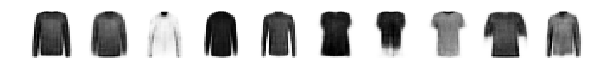

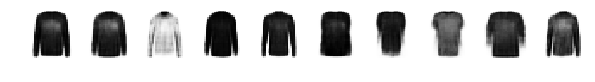

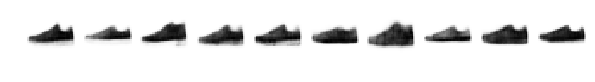

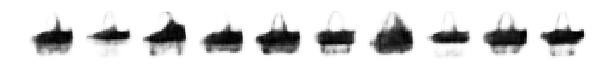

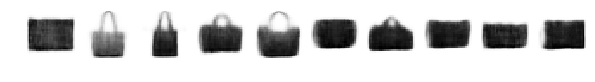

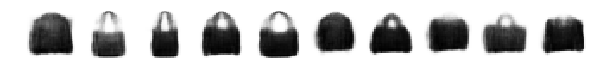

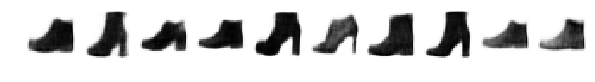

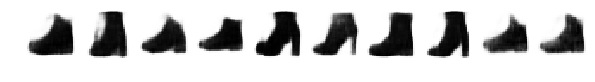

In [207]:
for k in range(10):
    inspect_number(feedfwd_z_vals[k], np.arange(10))
    inspect_number(feedfwd_z_with_handles[k], np.arange(10))

In [208]:
model

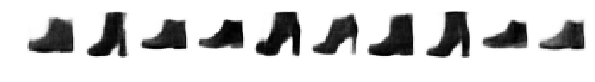

In [235]:
inspect_number(feedfwd_z[9], np.arange(10))

(30, 4)


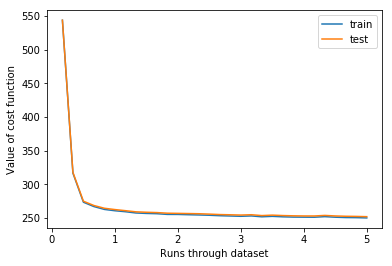

In [240]:
"""Plot training and testing costs"""

fig, ax = plt.subplots()
costs = pd.read_csv('costs.csv', index_col=[0])
print(costs.shape)

X = (np.arange(30) + 1) / 6
tr = costs.loc[:, 'train']
tst = costs.loc[:, 'test']
ax.plot(X, tr)
ax.plot(X, tst)
ax.set_xlabel('Runs through dataset')
ax.set_ylabel('Value of cost function')
ax.legend()
plt.savefig('costs.pdf')

In [241]:
model2 = AutoEncoder(dim_z=2, dim_conv1=2, dim_conv2=2, dim_hidden=2, 
                    learn_param=0.001)

ValueError: Variable enc_conv1/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-104-41a66685d3a5>", line 29, in _build_graph
    name='enc_conv1')    # 28x28 -> 14x14xdim_conv1
  File "<ipython-input-104-41a66685d3a5>", line 18, in __init__
    self._build_graph()
  File "<ipython-input-117-a599f5e1b689>", line 2, in <module>
    model = AutoEncoder(dim_z=16, dim_conv1=64, dim_conv2=128, dim_hidden=64, learn_param=0.001)


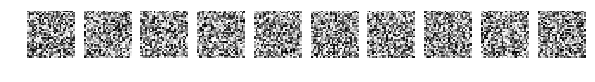

In [243]:
noise_z = np.random.rand(10, 784)
inspect_number(noise_z, np.arange(10))